# Поиск по изображению

Необходимо разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Загрузка необходимых библиотек

Загрузка данных с гугл диска.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# PATH = '/content/drive/MyDrive/to_upload'

Загрузка данных по ссылке.

In [ ]:
!wget -q https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -q dsplus_integrated_project_4.zip

PATH = '/content/to_upload'

Загрузка библиотек.

In [ ]:
!pip install catboost -q

In [ ]:
import pandas as pd
import numpy as np
import random
import os
from collections import Counter
from functools import lru_cache

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import re

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import transformers
from tqdm import notebook

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupShuffleSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи нужно эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок нужно выбрать либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


Загрузка датасетов.

In [ ]:
data_train = pd.read_csv(PATH + '/train_dataset.csv')
data_test = pd.read_csv(PATH + '/test_queries.csv', sep='|', index_col=0)
data_test_images = pd.read_csv(PATH + '/test_images.csv')
data_crowd_ann = pd.read_csv(PATH + '/CrowdAnnotations.tsv',
                             sep='\t',
                             names=['image', 'query_id', 'crowd_rating', 'count_pos', 'count_neg'])
data_exp_ann = pd.read_csv(PATH + '/ExpertAnnotations.tsv',
                           sep='\t',
                           names=['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'])

Исследуем датасеты.

In [ ]:
def info_func(name, data):
  print(name)
  display(data.head(15))
  print()
  print('Информация о датасете: ', name)
  print()
  display(data.info())
  print()
  print('Количество уникальных значений:')
  print()
  display(data.nunique())
  print()
  try:
    print('Количество дубликатов: ', data.duplicated(subset=['image', 'query_id']).sum())
  except:
    pass
  print()
  print()
  print()

In [ ]:
data_dict = {'data_train' : data_train,
             'data_test' : data_test,
             'data_test_images' : data_test_images,
             'data_crowd_ann' : data_crowd_ann,
             'data_exp_ann' : data_exp_ann}

for name, data in data_dict.items():
  info_func(name, data)

data_train


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
5,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
6,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
7,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
8,343218198_1ca90e0734.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
9,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...



Информация о датасете:  data_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None


Количество уникальных значений:



image         1000
query_id       977
query_text     977
dtype: int64


Количество дубликатов:  0



data_test


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg
5,1232148178_4f45cc3284.jpg#0,A baby girl playing at a park .,1232148178_4f45cc3284.jpg
6,1232148178_4f45cc3284.jpg#1,A closeup of a child on a playground with adul...,1232148178_4f45cc3284.jpg
7,1232148178_4f45cc3284.jpg#2,A young boy poses for a picture in front of a ...,1232148178_4f45cc3284.jpg
8,1232148178_4f45cc3284.jpg#3,A young girl is smiling in front of the camera...,1232148178_4f45cc3284.jpg
9,1232148178_4f45cc3284.jpg#4,There is a little blond hair girl with a green...,1232148178_4f45cc3284.jpg



Информация о датасете:  data_test

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None


Количество уникальных значений:



query_id      500
query_text    500
image         100
dtype: int64


Количество дубликатов:  0



data_test_images


,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg
5,424307754_1e2f44d265.jpg
6,3044359043_627488ddf0.jpg
7,3396275223_ee080df8b5.jpg
8,2977379863_2e8d7a104e.jpg
9,634891010_9fa189effb.jpg



Информация о датасете:  data_test_images

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


None


Количество уникальных значений:



image    100
dtype: int64





data_crowd_ann


,image,query_id,crowd_rating,count_pos,count_neg
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.000000,0,3
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,0.000000,0,3
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,0.333333,1,2
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,0.000000,0,3
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,0.000000,0,3



Информация о датасете:  data_crowd_ann

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47830 non-null  object 
 1   query_id      47830 non-null  object 
 2   crowd_rating  47830 non-null  float64
 3   count_pos     47830 non-null  int64  
 4   count_neg     47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None


Количество уникальных значений:



image           1000
query_id        1000
crowd_rating      12
count_pos          6
count_neg          7
dtype: int64


Количество дубликатов:  0



data_exp_ann


,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1
6,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,1,1,1
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1,1,2
8,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,1,1,1
9,106490881_5a2dd9b7bd.jpg,1714316707_8bbaa2a2ba.jpg#2,2,2,2



Информация о датасете:  data_exp_ann

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None


Количество уникальных значений:



image       1000
query_id     977
expert_1       4
expert_2       4
expert_3       4
dtype: int64


Количество дубликатов:  0





Представлены следующие датасеты:

- data_train - датасет с информацией для обучения модели, в нем находится имя файла изображения, идентификатор описания (имеет формат <имя файла изображения>#<порядковый номер описания>) и текст описания. В данном датасете 5822 строк, которые включают в себя 1000 уникальных изображений и 977 уникальных тестовых запросов. В датасете нет пропусков и дубликатов.
- data_test - датасет с информацией для тестирования модели, в нем находится имя файла изображения, идентификатор описания и текст описания. В данном датасете 500 строк, которые включают в себя 100 уникальных изображений и 500 уникальных тестовых запросов. В датасете нет пропусков и дубликатов.
- data_test_images - датасет с 100 уникальными изображениями.
- data_crowd_ann - датасет с данными по соответствию изображения и описания, полученные с помощью краудсорсинга, в нем находится имя файла изображения, идентификатор описания, доля людей, подтвердивших, что описание соответствует изображению, количество человек, подтвердивших, что описание соответствует изображению, количество человек, подтвердивших, что описание не соответствует изображению. В данном датасете 47830 строк, которые включают в себя 1000 уникальных изображений и 1000 уникальных тестовых запросов. В датасете нет пропусков и дубликатов.
- data_exp_ann - датасет с данными по соответствию изображения и описания, полученные в результате опроса экспертов, в нем находится имя файла изображения, идентификатор описания и оценки трех экспертов. В данном датасете 5822 строк, которые включают в себя 1000 уникальных изображений и 977 уникальных тестовых запросов. В датасете нет пропусков и дубликатов.

Проверим, нет ли совпадающих изображений в обучающем и тестовом датасетах.

In [ ]:
data_train['image'].equals(data_test['image'])

False

В обучающем и тестовом датасете нет совпадающих изображений.

Изучим оценки экспертов.

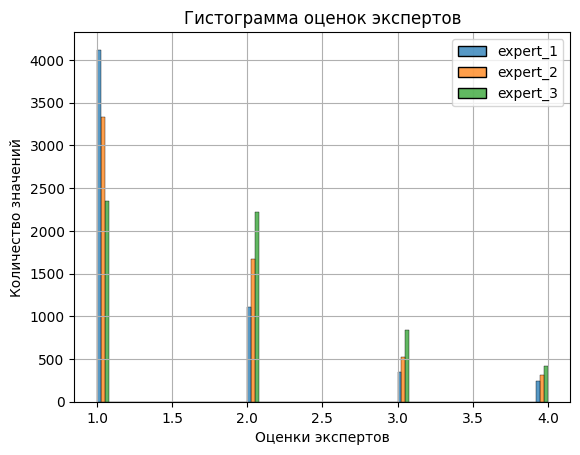

In [ ]:
sns.histplot(data_exp_ann.loc[:,['expert_1','expert_2', 'expert_3']], multiple='dodge');
plt.title('Гистограмма оценок экспертов');
plt.xlabel('Оценки экспертов');
plt.ylabel('Количество значений');
plt.grid(True);

Эксперты чаще всего оценивали соответствие текста изображению как "изображение и запрос совершенно не соответствуют друг другу" и "запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует".

Агрегируем и отмасштабируем оценки экспертов. Если мнение хотя бы двух экспертов сопадает - берем их оценку, в обратном случае - среднее.

In [ ]:
def agregate_func(data_exp_ann):
  if data_exp_ann['expert_1'] != data_exp_ann['expert_2'] != data_exp_ann['expert_3']:
    return (data_exp_ann['expert_1'] + data_exp_ann['expert_2'] + data_exp_ann['expert_3']) / 3
  else:
    return Counter([data_exp_ann['expert_1'], data_exp_ann['expert_2'], data_exp_ann['expert_3']]).most_common(1)[0][0]

data_exp_ann['expert_rating'] = data_exp_ann.apply(agregate_func, axis=1)

data_exp_ann['expert_rating'] = (data_exp_ann['expert_rating']-data_exp_ann['expert_rating'].min())/ \
                                   (data_exp_ann['expert_rating'].max()-data_exp_ann['expert_rating'].min())

Объединим обучающий и тестовый датасеты с оценками экспертов и с оценками с краудсорсинга.

In [ ]:
data_rating = data_exp_ann.loc[:,['image','query_id', 'expert_rating']].merge(data_crowd_ann.loc[:, ['image','query_id', 'crowd_rating']],
                                                                      on=['image','query_id'],
                                                                      how='left')
data_train = data_train.merge(data_rating, on=['image','query_id'], how='inner')

Проверим, имеются ли пропуски в объединенном датасете.

In [ ]:
data_train.isna().sum()

image               0
query_id            0
query_text          0
expert_rating       0
crowd_rating     3493
dtype: int64

Пропуски имеются в оценках с краудсорсинга.

Построим гистограммы оценок экспертов и оценок с краудсорсинга.

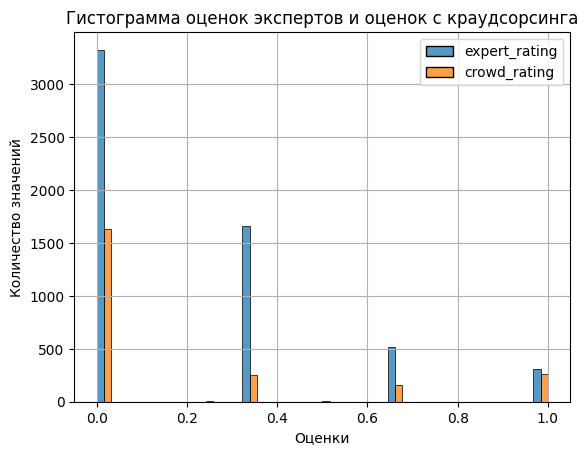

In [ ]:
sns.histplot(data_train.loc[:,['expert_rating', 'crowd_rating']], multiple='dodge');
plt.title('Гистограмма оценок экспертов и оценок с краудсорсинга');
plt.xlabel('Оценки');
plt.ylabel('Количество значений');
plt.grid(True);

Оценки с краудсоринга чаще всего показывают, что текст и изображение не соотвествуют друг другу, как и в случае оценок экспертов.

Как целевой признак будем использовать только оценки экспертов, так как это повысит качество данных.

In [ ]:
## метод агрегации полученных оценок экспертов и оценок с краудсорсинга с применением коэффициента,
## который в меньшей степени учитывает оценки с краудосорсинга, так как в них имеются пропуски и возможные несоответствия.
## (использовался раннее)

# def exp_and_crowd_agregate_func(data_train):
#     if np.isnan(data_train['expert_rating']):
#         return data_train['crowd_rating']
#     elif np.isnan(data_train['crowd_rating']):
#         return data_train['expert_rating']
#     else:
#         return data_train['expert_rating'] * 0.8 + data_train['crowd_rating'] * 0.2
# data_train['matching_text_to_image'] = data_train.apply(exp_and_crowd_agregate_func, axis=1)

data_train['matching_text_to_image'] = data_train['expert_rating']

data_train = data_train.drop(['crowd_rating', 'expert_rating', 'query_id'], axis=1)

Выведем итоговый датасет и информацию о нем.

In [ ]:
display(data_train.head())
data_train.info()

,image,query_text,matching_text_to_image
0,1056338697_4f7d7ce270.jpg,A young child is wearing blue goggles and sitt...,0.000000
1,1262583859_653f1469a9.jpg,A young child is wearing blue goggles and sitt...,0.000000
2,2447284966_d6bbdb4b6e.jpg,A young child is wearing blue goggles and sitt...,0.333333
3,2549968784_39bfbe44f9.jpg,A young child is wearing blue goggles and sitt...,1.000000
4,2621415349_ef1a7e73be.jpg,A young child is wearing blue goggles and sitt...,0.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   image                   5822 non-null   object 
 1   query_text              5822 non-null   object 
 2   matching_text_to_image  5822 non-null   float64
dtypes: float64(1), object(2)
memory usage: 181.9+ KB


Вывод:

Были изучены следующие датасеты:

- data_train - датасет с информацией для обучения модели, в нем находится имя файла изображения, идентификатор описания (имеет формат <имя файла изображения>#<порядковый номер описания>) и текст описания. В данном датасете 5822 строк, которые включают в себя 1000 уникальных изображений и 977 уникальных тестовых запросов. В датасете нет пропусков и дубликатов.
- data_test - датасет с информацией для тестирования модели, в нем находится имя файла изображения, идентификатор описания и текст описания. В данном датасете 500 строк, которые включают в себя 100 уникальных изображений и 500 уникальных тестовых запросов. В датасете нет пропусков и дубликатов.
- data_test_images - датасет с 100 уникальными изображениями.
- data_crowd_ann - датасет с данными по соответствию изображения и описания, полученные с помощью краудсорсинга, в нем находится имя файла изображения, идентификатор описания, доля людей, подтвердивших, что описание соответствует изображению, количество человек, подтвердивших, что описание соответствует изображению, количество человек, подтвердивших, что описание не соответствует изображению. В данном датасете 47830 строк, которые включают в себя 1000 уникальных изображений и 1000 уникальных тестовых запросов. В датасете нет пропусков и дубликатов.
- data_exp_ann - датасет с данными по соответствию изображения и описания, полученные в результате опроса экспертов, в нем находится имя файла изображения, идентификатор описания и оценки трех экспертов. В данном датасете 5822 строк, которые включают в себя 1000 уникальных изображений и 977 уникальных тестовых запросов. В датасете нет пропусков и дубликатов.

В обучающем и тестовом датасете нет совпадающих изображений.

В датафрейме data_test все описания и изображения соответствуют друг другу.

Датафреймы data_train и data_exp_ann содержат одни и те же объекты (пары изображение/описание).

Были объединены обучающий и тестовый датасеты с оценками экспертов и с оценками с краудсорсинга. После объединения были обнаружены пропуски в оценках с краудсорсинга.

Были изучены оценки экспертов и оценки с краудсорсинга:
- Эксперты чаще всего оценивали соответствие текста изображению как "изображение и запрос совершенно не соответствуют друг другу" и "запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует".
- Оценки с краудсоринга чаще всего показывают, что текст и изображение не соотвествуют друг другу, как и в случае оценок экспертов.

Были агрегированы и отмасштабированы оценки экспертов. Если мнение хотя бы двух экспертов сопадает - брали их оценку, в обратном случае - среднее. Как целевой признак будут использоваться только оценки экспертов, так как это повысит качество данных.

## 2. Проверка данных

В некоторых странах, где работает компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Создадим массив с стоп-словами, которые необходимо удалить из датасета.

In [ ]:
stop_list = ['baby', 'child', 'teenager', 'teenage', 'girl', 'boy', 'kid', 'schoolboy', 'youth', 'newborn', 'toddler', 'children']

Проведем лемматизацию текста с помощью WordNetLemmatizer(), лемматизированный текст может пригодится также при векторизации текста при помощи tf-idf.

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
%%time
def lemmatize_func(text):
    clear_text = re.sub(r'[^a-zA-z]', ' ', text).lower().split()
    lemm_text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in clear_text])
    return lemm_text

data_train['query_text'] = data_train['query_text'].apply(lemmatize_func)

CPU times: user 11.7 s, sys: 821 ms, total: 12.5 s
Wall time: 17 s


Удалим из датасета строки, содержащие стоп-слова, но предварителньо проверим сколько данных подлежит удалению.

In [ ]:
def define_stop_word_func(data_train, stop_list):
  if (len(set(data_train['query_text'].split()) & set(stop_list)) > 0) & \
      (data_train['matching_text_to_image'] > 0.4):
    return 1
  else:
    return 0

data_train['presence_stop_word'] = data_train.apply(define_stop_word_func, args=[stop_list], axis=1)

In [ ]:
data_train['presence_stop_word'].value_counts()

0    5689
1     133
Name: presence_stop_word, dtype: int64

In [ ]:
data_train = data_train.query('presence_stop_word == 0')

data_train = data_train.drop(['presence_stop_word'], axis=1)

Вывод:

Был подготовлен список стоп-слов, наличие которых недопустимо в датасете. Из датасета были удалены строки, в которых содержались стоп-слова.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Загрузим претренированную модель ResNet-18.

In [ ]:
resnet = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Заморозим веса модели, так как ее не требуется обучать.

In [ ]:
for param in resnet.parameters():
    param.requires_grad_(False)

Для получения эмбеддингов нам потребуется все слои кроме последнего.

In [ ]:
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)

Переведем модель в режим предсказания.

In [ ]:
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

Приведем изображение в нужный формат: зададим размер изображения, вырежем центр и нормализуем.

In [ ]:
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

Посмотрим на изображения из датасета и получим эмбеддинги для каждого изображения.

In [ ]:
@lru_cache(maxsize=None)
def vectorize_image_func(path, image_name):
    img = Image.open(path + image_name).convert('RGB')
    image_tensor = preprocess(img)
    return resnet(image_tensor.unsqueeze(0)).flatten().numpy()

# def vectorize_image_func(path, data):
#   output_tensor_image = []
#   for image_name in data_train['image']:
#       img = Image.open(path + image_name).convert('RGB')
#       image_tensor = preprocess(img)
#       output_tensor_image.append(resnet(image_tensor.unsqueeze(0)).flatten().numpy())
#   return output_tensor_image

In [ ]:
%%time
output_tensor_image_train = []
for image_name in data_train['image']:
    output_tensor_image_train.append(vectorize_image_func(PATH + '/train_images/', image_name))

# output_tensor_image_train = vectorize_image_func(PATH + '/train_images/', data_train)

CPU times: user 1min 54s, sys: 317 ms, total: 1min 54s
Wall time: 2min 2s


In [ ]:
vectorize_image_func.cache_info()

CacheInfo(hits=4689, misses=1000, maxsize=None, currsize=1000)

Посмотрим размерность полученного вектора.

In [ ]:
print(len(output_tensor_image_train), ':', len(output_tensor_image_train[0]))

5689 : 512


Вывод:

Была проведена векторизация изображений обучающего датасета при помощи
предварительно натренированной на датасете ImageNet ResNet-18, у которой были исключены полносвязные слои, которые отвечают за конечное предсказание.

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Можно поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- трансформеры (например Bert)


In [ ]:
##Применим tf-idf.

## Выгрузим стоп-слова
# nltk.download('stopwords')
# stopwords = set(nltk_stopwords.words('english'))

# count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))

# output_tensor_text_train = count_tf_idf.fit_transform(data_train['query_text']).toarray()

Применим DistilBERT для векторизации текста и загрузим предобученною модель DistilBERT и токенизатор.

In [ ]:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel,
                                                    transformers.DistilBertTokenizer,
                                                    'distilbert-base-uncased')
#model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, 'bert-base-uncased') # базовая BERT

Загрузка предобученной модели/токенизатора

In [ ]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Проведем векторизацию текста.

In [ ]:
def vectorize_text_func(data):

  # токенизируем текст
  tokenized = data.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

  # найдем максимальную длину векторов после токенизации
  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  # применим padding к векторам
  # англ. вектор с отступами
  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

  # создадим маску для важных токенов
  attention_mask = np.where(padded != 0, 1, 0)

  # преобразуем данные в формат тензоров
  input_ids = torch.tensor(np.array(padded))
  attention_mask = torch.tensor(np.array(attention_mask))

  batch_size = 100

  # сделаем пустой список для хранения эмбеддингов твитов
  embeddings = []

  for i in notebook.tqdm(range(input_ids.shape[0] // batch_size + 1)):
      batch = input_ids[batch_size*i:batch_size*(i+1)]
      attention_mask_batch = attention_mask[batch_size*i:batch_size*(i+1)]

      with torch.no_grad(): # для ускорения вычисления функцией no_grad() в библиотеке torch укажем, что градиенты не нужны: модель BERT обучать не будем.
          batch_embeddings = model(batch, attention_mask=attention_mask_batch) #передадим модели данные и маску

      embeddings.append(batch_embeddings[0][:,0,:].numpy())  # преобразуем элементы методом numpy() к типу numpy.array

  output_tensor_text = np.concatenate(embeddings)
  return output_tensor_text

In [ ]:
%%time
output_tensor_text_train = vectorize_text_func(data_train['query_text'])

  0%|          | 0/57 [00:00<?, ?it/s]

CPU times: user 4min 43s, sys: 21.3 s, total: 5min 5s
Wall time: 5min 22s


Посмотрим размерность полученного вектора.

In [ ]:
print(len(output_tensor_text_train), ':', len(output_tensor_text_train[0]))

5689 : 768


Вывод:

Была проведена векторизация текста обучающего датасета при помощи DistilBERT.

## 5. Объединение векторов

Подготовим данные для обучения: объединим векторы изображений и векторы текстов с целевой переменной.

In [ ]:
features = np.concatenate([output_tensor_image_train, output_tensor_text_train], axis=1)
target = np.array(data_train['matching_text_to_image'])

Вывод:

Были объединены векторы изображений и векторы текстов в один вектор признаков, была подготовлена целевая переменная.

## 6. Обучение модели предсказания соответствия

Для обучения разделим датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Разобьем датасет на обучающую и тестовую выборку.

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
train_indices, valid_indices = next(gss.split(X=features, y=target, groups=data_train['image']))
features_train, features_valid = features[train_indices], features[valid_indices]
target_train, target_valid = target[train_indices], target[valid_indices]

Отмасштабируем наши данные.

In [ ]:
scaler = StandardScaler().fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)

Обучим следующие модели и проверим ик качество на валидационной выборке: LinearRegression(), CatBoostRegressor(), полносвязная нейронная сеть. Метрика для оценки качества была выбрана RMSE, так как она  подходит для задачи регрессии и позволяет учесть все отклонения модели от истинных значений.

Получим метрику на константной модели, чтобы проверить полученную  модель на адекватность.

In [ ]:
dummy = DummyRegressor(strategy='mean').fit(features_train, target_train)
predictions_dummy = dummy.predict(features_valid)
rmse = mean_squared_error(target_valid, predictions_dummy)**0.5
rmse

0.26761412756148767

Обучим модель LinearRegression().

In [ ]:
%%time
lr = LinearRegression()
lr.fit(features_train, target_train)
predictions_lr = lr.predict(features_valid)
rmse = mean_squared_error(target_valid, predictions_lr)**0.5
rmse

CPU times: user 1.92 s, sys: 292 ms, total: 2.21 s
Wall time: 1.26 s


0.3322637048931556

Полученная метрика на LinearRegression() равняется 0.332, что выше метрики константной модели, это связано с переобучением модели без регуляризации.

Обучим модель CatBoostRegressor().

In [ ]:
%%time
cbr = CatBoostRegressor(random_state=13, depth=6)
cbr.fit(features_train, target_train)
predictions_cbr = cbr.predict(features_valid)
rmse = mean_squared_error(target_valid, predictions_cbr)**0.5
rmse

Learning rate set to 0.052033
0:	learn: 0.2728246	total: 759ms	remaining: 12m 38s
1:	learn: 0.2714745	total: 1.12s	remaining: 9m 17s
2:	learn: 0.2698506	total: 1.47s	remaining: 8m 8s
3:	learn: 0.2682723	total: 1.83s	remaining: 7m 36s
4:	learn: 0.2669409	total: 2.18s	remaining: 7m 13s
5:	learn: 0.2657396	total: 2.53s	remaining: 6m 58s
6:	learn: 0.2644316	total: 2.89s	remaining: 6m 50s
7:	learn: 0.2632129	total: 3.23s	remaining: 6m 41s
8:	learn: 0.2621850	total: 3.58s	remaining: 6m 34s
9:	learn: 0.2609470	total: 3.95s	remaining: 6m 31s
10:	learn: 0.2597292	total: 4.29s	remaining: 6m 25s
11:	learn: 0.2586516	total: 4.64s	remaining: 6m 21s
12:	learn: 0.2576177	total: 5s	remaining: 6m 19s
13:	learn: 0.2567864	total: 5.42s	remaining: 6m 21s
14:	learn: 0.2553517	total: 6s	remaining: 6m 33s
15:	learn: 0.2546671	total: 6.58s	remaining: 6m 44s
16:	learn: 0.2538090	total: 7.19s	remaining: 6m 56s
17:	learn: 0.2530698	total: 7.76s	remaining: 7m 3s
18:	learn: 0.2523097	total: 8.32s	remaining: 7m 9s


0.2185055185657413

Полученная метрика на CatBoostRegressor() равняется 0.219, что меньше метрики константной модели (результат адекватен).

Обучим полносвязную нейронную сеть.

Преобразуем датасеты с признаками в тензоры.

In [ ]:
features_train = torch.FloatTensor(features_train)
features_valid = torch.FloatTensor(features_valid)
target_train = torch.FloatTensor(target_train)
target_valid = torch.FloatTensor(target_valid)

Создадим класс для задания архитектуры нейронной сети и обучим ее.

In [ ]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3,  n_hidden_neurons_4, n_out_neurons):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.bn3 = nn.BatchNorm1d(n_hidden_neurons_3)
        self.act3 = nn.ReLU()

        self.fc4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
        self.bn4 = nn.BatchNorm1d(n_hidden_neurons_4)
        self.act4 = nn.ReLU()

        self.fc5 = nn.Linear(n_hidden_neurons_4, n_out_neurons)
        self.act5 = nn.Sigmoid()

        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc1.bias)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc2.bias)
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc3.bias)
        nn.init.kaiming_normal_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc5.bias)
        nn.init.kaiming_normal_(self.fc5.weight, mode='fan_in', nonlinearity='sigmoid')
        nn.init.normal_(self.fc5.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.act3(x)

        x = self.fc4(x)
        x = self.bn4(x)
        x = self.act4(x)

        x = self.fc5(x)
        x = self.act5(x)
        return x

In [ ]:
%%time
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

n_in_neurons = features_train.shape[1]
n_hidden_neurons_1 = 512
n_hidden_neurons_2 = 256
n_hidden_neurons_3 = 64
n_hidden_neurons_4 = 16
n_out_neurons = 1

# инициализируем парметры нейросети
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_hidden_neurons_4, n_out_neurons)
# алгоритм оптимизации Adam
optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
# зададим функцию потерь (для задачи регрессии MSELoss)
loss = nn.MSELoss()

num_epochs = 600

best_rmse = 0.3

for epoch in range(num_epochs):
    # обнуление градиентов
    optimizer.zero_grad()
    # прямое распространение на обучающих данных
    preds = net.forward(features_train).flatten()
    # вычисление значения функции потерь
    loss_value = loss(preds, target_train)
    # вычисление градиентов
    loss_value.backward()
    # один шаг оптимизации весов
    optimizer.step()

    if epoch % 50 == 0 or epoch == num_epochs-1:
        # перевод сети в режим предсказания
        net.eval()
        # прямое распространение на тестовых данных
        test_preds = net.forward(features_valid).flatten()
        # вычисление RMSE
        rmse = np.sqrt(mean_squared_error(target_valid.detach().numpy(), test_preds.detach().numpy()))
        print(f'Эпоха: {epoch}, RMSE: {rmse}')

    if rmse < best_rmse:
        best_rmse = rmse
        best_epoch = epoch
        best_test_preds = test_preds.detach().numpy()
print('')
print(f'Эпоха: {best_epoch}, лучший RMSE: {best_rmse}')

Эпоха: 0, RMSE: 0.2796274721622467
Эпоха: 50, RMSE: 0.25871238112449646
Эпоха: 100, RMSE: 0.24778114259243011
Эпоха: 150, RMSE: 0.2419220209121704
Эпоха: 200, RMSE: 0.23763446509838104
Эпоха: 250, RMSE: 0.23404675722122192
Эпоха: 300, RMSE: 0.23098620772361755
Эпоха: 350, RMSE: 0.2286561280488968
Эпоха: 400, RMSE: 0.22696912288665771
Эпоха: 450, RMSE: 0.22612188756465912
Эпоха: 500, RMSE: 0.2259134203195572
Эпоха: 550, RMSE: 0.22622007131576538
Эпоха: 599, RMSE: 0.22643209993839264

Эпоха: 500, лучший RMSE: 0.2259134203195572
CPU times: user 3min 19s, sys: 265 ms, total: 3min 19s
Wall time: 3min 25s


Полученная метрика на полносвязной нейронной сети равняется 0.226, что меньше метрики константной модели (результат адекватен).

Вывод:

Данные были разбиты на обучающую и тестовую выборки при помощи GroupShuffleSplit и отмасштабированы при помощи StandardScaler.

Были обучены следующие модели и проверено ик качество на валидационной выборке: LinearRegression(), CatBoostRegressor(), полносвязная нейронная сеть. Метрика для оценки качества была выбрана RMSE, так как она подходит для задачи регрессии и позволяет учесть все отклонения модели от истинных значений.

- Была получена метрика на константной модели DummyRegressor, которая равняется 0.277.

- Полученная метрика на LinearRegression() равняется 0.332, что выше метрики константной модели, это связано с переобучением модели без регуляризации.

- Полученная метрика на CatBoostRegressor() равняется 0.219, что меньше метрики константной модели (результат адекватен).

- Полученная метрика на полносвязной нейронной сети равняется 0.226, что меньше метрики константной модели (результат адекватен).

## 7. Тестирование модели

Настало время протестировать модель. Для этого надо получить эмбеддинги для всех тестовых изображений из папки `test_images`, выберать случайные 10 запросов из файла `test_queries.csv` и для каждого запроса вывести наиболее релевантное изображение. Необходимо равнить визуально качество поиска.

Напишем функцию, которая на вход принимает текстовый запрос и на выход выдает наиболее релевантное изображение. Векторизацию тестовых изображений проведем заранее. Также в функции реализано предубреждение о неверном вводе запроса, при использовании в нем стоп-слов. Для получения тестовых предсказаний используем нейронную сеть, так как она на практике лучше подбирает изображения тексту, хотя и метрика ниже чем у CatBoostRegressor.

In [ ]:
output_tensor_image_test = []
for image_name in data_test_images['image']:
    output_tensor_image_test.append(vectorize_image_func(PATH + '/test_images/', image_name))

In [ ]:
def find_image(model, data, text, output_tensor_image, stop_list=stop_list, path=PATH):

  lemm_text = lemmatize_func(text)

  if len(set(lemm_text.split()) & set(stop_list)) > 0:
    print(text + ' - Некорректный запрос')
  else:
    output_tensor_text_one_element = vectorize_text_func(pd.Series([text]))
    output_tensor_text = output_tensor_text_one_element[0] * np.ones((len(output_tensor_image), len(output_tensor_text_one_element)))

    features = np.concatenate((output_tensor_image, output_tensor_text), axis=1)

    features = scaler.transform(features)

    features = torch.FloatTensor(features)
    model.eval()
    predictions = model.forward(features).flatten()

    # predictions = model.predict(features)
    data['matching_text_to_image'] = predictions.detach().numpy()

    data = data.sort_values(by='matching_text_to_image', ascending=False).reset_index(drop=True)

    fig = plt.figure(figsize=(5,5))
    img = Image.open(path + '/test_images/' + data.loc[0,'image']).convert('RGB')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(text)
  return

Выведем получившиеся изображения.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

A man lies on a blue blanket with a child on his back . - Некорректный запрос


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Two boys playing in water . - Некорректный запрос


  0%|          | 0/1 [00:00<?, ?it/s]

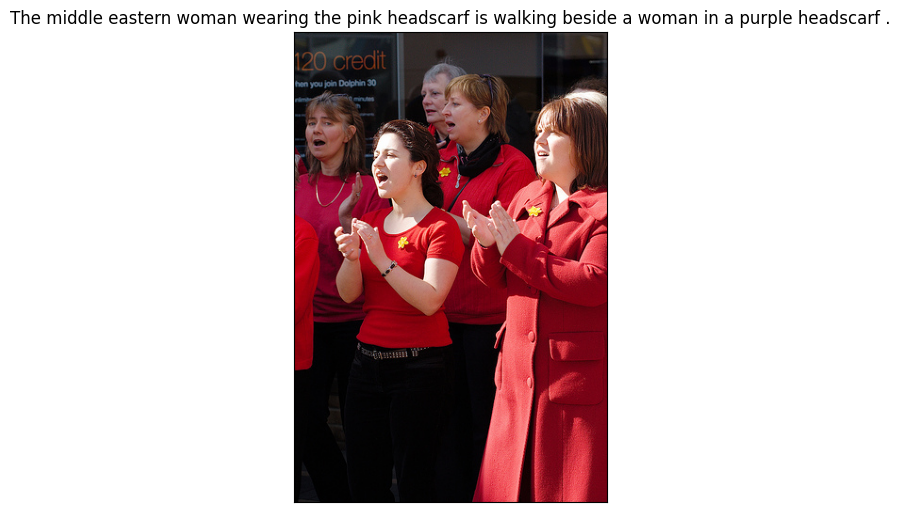

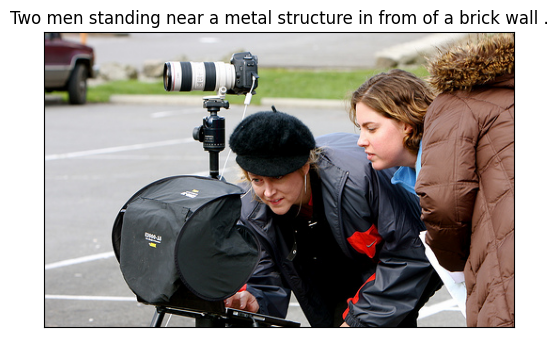

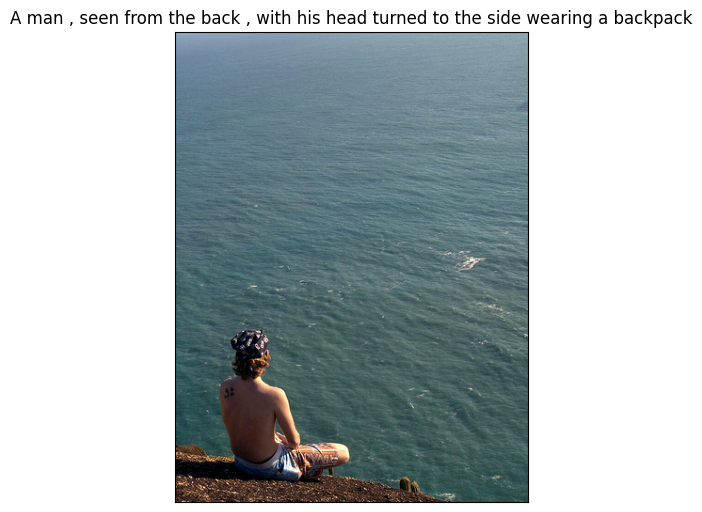

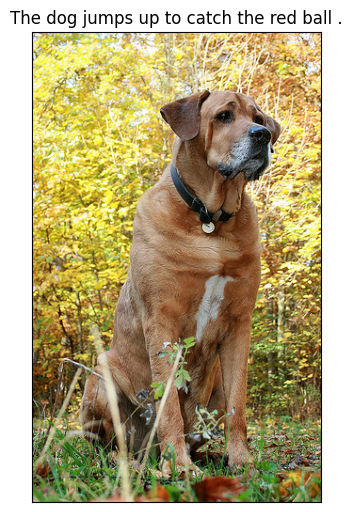

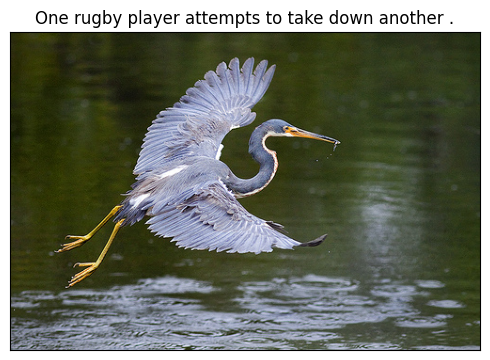

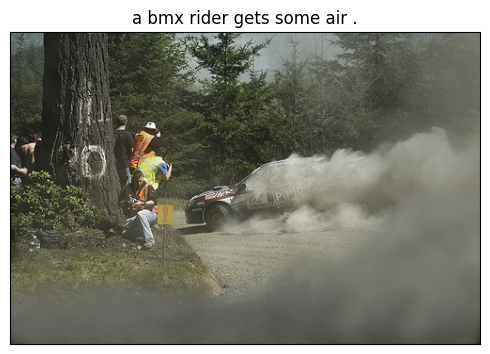

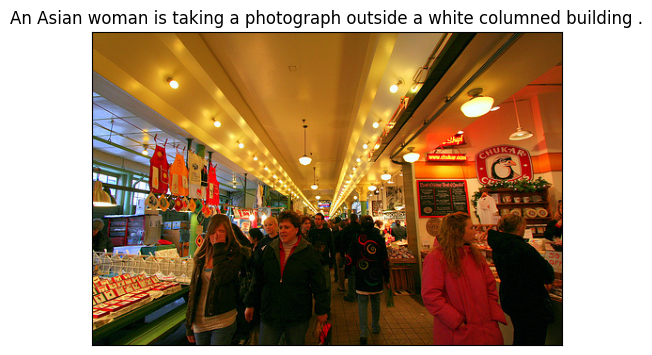

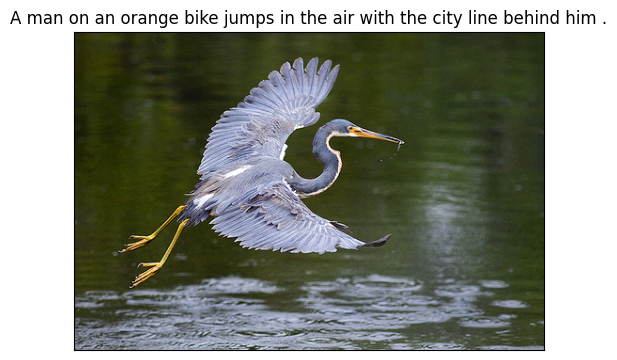

In [ ]:
texts = np.random.choice(data_test['query_text'].unique(), 10)

for text in texts:
  find_image(net, data_test_images, text, output_tensor_image_test)

Вывод:

Было проведено тестирование : была написана функция, которая на вход принимает текстовый запрос и на выход выдает наиболее релевантное изображение. Для получения тестовых предсказаний использовалась нейронная сеть - на практике она лучше подбирает изображения к тексту, чем CatBoostRegressor, метрика которого больше. Используемая нейронная сеть включает в себя 5 слоев и Batch Normalization.

Часть изображений частично соотвествует описанию (изображение с собакой и текст про собаку; мужчина на велосипеде - текст про мужчину на велосипеде), но результат тестирования тяжело назвать удовлетворительным, так как часть изображений полностью не соответствуют своему описанию.

Для улучшения качества могут быть приняты следующие меры:
- Необходимо использовать больше данных для обучения.
- Данные должны быть качественно оценены на соответствие описанию.
- Изображения и запросы для обучения модели должны быть адекватными.
- Можно лучше подобрать гиперпарметры используемых моделей или попробовать использовать другие модели.
- Попробовать другие методы векторизации текста и изображений.
- Попробовать другие методы агрегировнаия оценок экспертов и оценок с краудсорсинга.

**Общий вывод**

**Исследовательский анализ данных**

Были изучены следующие датасеты:

- data_train - датасет с информацией для обучения модели, в нем находится имя файла изображения, идентификатор описания (имеет формат <имя файла изображения>#<порядковый номер описания>) и текст описания. В данном датасете 5822 строк, которые включают в себя 1000 уникальных изображений и 977 уникальных тестовых запросов. В датасете нет пропусков и дубликатов.
- data_test - датасет с информацией для тестирования модели, в нем находится имя файла изображения, идентификатор описания и текст описания. В данном датасете 500 строк, которые включают в себя 100 уникальных изображений и 500 уникальных тестовых запросов. В датасете нет пропусков и дубликатов.
- data_test_images - датасет с 100 уникальными изображениями.
- data_crowd_ann - датасет с данными по соответствию изображения и описания, полученные с помощью краудсорсинга, в нем находится имя файла изображения, идентификатор описания, доля людей, подтвердивших, что описание соответствует изображению, количество человек, подтвердивших, что описание соответствует изображению, количество человек, подтвердивших, что описание не соответствует изображению. В данном датасете 47830 строк, которые включают в себя 1000 уникальных изображений и 1000 уникальных тестовых запросов. В датасете нет пропусков и дубликатов.
- data_exp_ann - датасет с данными по соответствию изображения и описания, полученные в результате опроса экспертов, в нем находится имя файла изображения, идентификатор описания и оценки трех экспертов. В данном датасете 5822 строк, которые включают в себя 1000 уникальных изображений и 977 уникальных тестовых запросов. В датасете нет пропусков и дубликатов.

В обучающем и тестовом датасете нет совпадающих изображений.

В датафрейме data_test все описания и изображения соответствуют друг другу.

Датафреймы data_train и data_exp_ann содержат одни и те же объекты (пары изображение/описание).

Были объединены обучающий и тестовый датасеты с оценками экспертов и с оценками с краудсорсинга. После объединения были обнаружены пропуски в оценках с краудсорсинга.

Были изучены оценки экспертов и оценки с краудсорсинга:
- Эксперты чаще всего оценивали соответствие текста изображению как "изображение и запрос совершенно не соответствуют друг другу" и "запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует".
- Оценки с краудсоринга чаще всего показывают, что текст и изображение не соотвествуют друг другу, как и в случае оценок экспертов.

Были агрегированы и отмасштабированы оценки экспертов. Если мнение хотя бы двух экспертов сопадает - брали их оценку, в обратном случае - среднее. Как целевой признак будут использоваться только оценки экспертов, так как это повысит качество данных.


**Проверка данных**

Был подготовлен список стоп-слов, наличие которых недопустимо в датасете. Из датасета были удалены строки, в которых содержались стоп-слова.


**Векторизация изображений**

Была проведена векторизация изображений обучающего датасета при помощи
предварительно натренированной на датасете ImageNet ResNet-18, у которой были исключены полносвязные слои, которые отвечают за конечное предсказание.


**Векторизация текстов**

Была проведена векторизация текста обучающего датасета при помощи DistilBERT.

**Объединение векторов**

Были объединены векторы изображений и векторы текстов в один вектор признаков, была подготовлена целевая переменная.


**Обучение модели предсказания соответствия**

Данные были разбиты на обучающую и тестовую выборки при помощи GroupShuffleSplit и отмасштабированы при помощи StandardScaler.

Были обучены следующие модели и проверено ик качество на валидационной выборке: LinearRegression(), CatBoostRegressor(), полносвязная нейронная сеть. Метрика для оценки качества была выбрана RMSE, так как она подходит для задачи регрессии и позволяет учесть все отклонения модели от истинных значений.

- Была получена метрика на константной модели DummyRegressor, которая равняется 0.277.

- Полученная метрика на LinearRegression() равняется 0.332, что выше метрики константной модели, это связано с переобучением модели без регуляризации.

- Полученная метрика на CatBoostRegressor() равняется 0.219, что меньше метрики константной модели (результат адекватен).

- Полученная метрика на полносвязной нейронной сети равняется 0.226, что меньше метрики константной модели (результат адекватен).

**Тестирование модели**

Было проведено тестирование : была написана функция, которая на вход принимает текстовый запрос и на выход выдает наиболее релевантное изображение. Для получения тестовых предсказаний использовалась нейронная сеть - на практике она лучше подбирает изображения к тексту, чем CatBoostRegressor, метрика которого больше. Используемая нейронная сеть включает в себя 5 слоев и Batch Normalization.

Часть изображений частично соотвествует описанию (изображение с собакой и текст про собаку; мужчина на велосипеде - текст про мужчину на велосипеде), но результат тестирования тяжело назвать удовлетворительным, так как часть изображений полностью не соответствуют своему описанию.

Для улучшения качества могут быть приняты следующие меры:
- Необходимо использовать больше данных для обучения.
- Данные должны быть качественно оценены на соответствие описанию.
- Изображения и запросы для обучения модели должны быть адекватными.
- Можно лучше подобрать гиперпарметры используемых моделей или попробовать использовать другие модели.
- Попробовать другие методы векторизации текста и изображений.
- Попробовать другие методы агрегировнаия оценок экспертов и оценок с краудсорсинга.